<a href="https://colab.research.google.com/github/GitGeekAritra/PRODIGY_GA_05/blob/main/GA_Task05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import requests
from io import BytesIO


In [15]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content))

def load_img(img, max_dim=512):
    img = img.convert('RGB')
    img = np.array(img)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


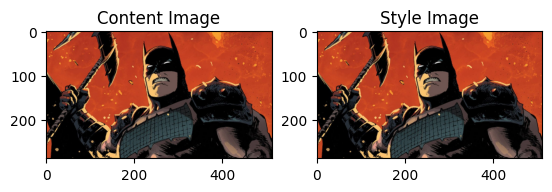

In [16]:
content_url = 'https://sm.ign.com/t/ign_in/feature/9/9-ways-abs/9-ways-absolute-batman-reinvents-the-dark-knights-mythology_e7jy.1200.jpg'
style_url = 'https://sm.ign.com/t/ign_in/feature/9/9-ways-abs/9-ways-absolute-batman-reinvents-the-dark-knights-mythology_e7jy.1200.jpg'
content_pil = download_image(content_url)
style_pil = download_image(style_url)

content_image = load_img(content_pil)
style_image = load_img(style_pil)


plt.subplot(1, 2, 1)
plt.imshow(tensor_to_image(content_image))
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(style_image))
plt.title('Style Image')
plt.show()


In [17]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [18]:
def vgg_layers(layer_names):
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:len(self.style_layers)],
                                          outputs[len(self.style_layers):])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [19]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.keras.optimizers.Adam(learning_rate=0.02)

style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 288, 512, 3))
  warnings.warn(msg)


In [21]:

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

import time
start = time.time()

epochs = 2
steps_per_epoch = 30

print("Training started...\n")
for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
    print(f" Epoch {n+1} completed")

end = time.time()
print("\n Total time: {:.1f} seconds".format(end - start))


Training started...

 Epoch 1 completed
 Epoch 2 completed

 Total time: 230.6 seconds


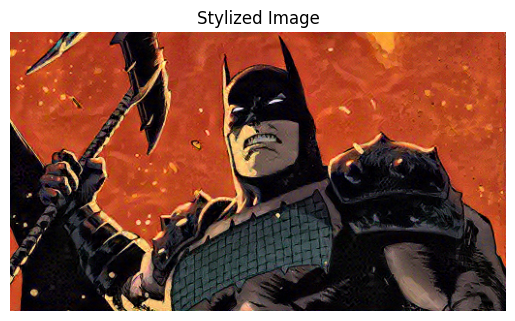

In [23]:
final_image = tensor_to_image(image)
plt.imshow(final_image)
plt.title("Stylized Image")
plt.axis('off')
plt.show()
